# Localizing Microscopic Particles


<div style="background-color: #f0f8ff; border: 2px solid #4682b4; padding: 10px;">
<a href="https://colab.research.google.com/github/DeepTrackAI/DeepLearningCrashCourse/blob/main/Ch03_CNN/ec03_B_particle_localization/particle_localization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>
<strong>If using Colab/Kaggle:</strong> You need to uncomment the code in the cell below this one.
</div>

In [277]:
!pip install deeplay deeptrack  # Uncomment if using Colab/Kaggle.

In [278]:
from google.colab import drive
drive.mount('/content/drive')

import os
os.chdir('/content/drive/My Drive/HW1Q4')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


This notebook provides you with a complete code example that trains a convolutional neural network with a dense top using annotated and simulated data and then applies it to experimental videos of an optically trapped particle.

<div style="background-color: #f0f8ff; border: 2px solid #4682b4; padding: 10px;">
<strong>Note:</strong> This notebook contains the Code Example 3-B from the book  

**Deep Learning Crash Course**  
Benjamin Midtvedt, Jesús Pineda, Henrik Klein Moberg, Harshith Bachimanchi, Joana B. Pereira, Carlo Manzo, Giovanni Volpe  
No Starch Press, San Francisco (CA), 2025  
ISBN-13: 9781718503922  

[https://nostarch.com/deep-learning-crash-course](https://nostarch.com/deep-learning-crash-course)

You can find the other notebooks on the [Deep Learning Crash Course GitHub page](https://github.com/DeepTrackAI/DeepLearningCrashCourse).
</div>

## Loading the Videos

Download the `particle_dataset`. This folder contains two videos with an optically trapped particle. One video is acquired with very low noise (`low_noise.avi`), while the other with very high noise (`high_noise.avi`).

In [279]:
import os

if not os.path.exists("particle_dataset"):
    os.system("git clone https://github.com/DeepTrackAI/particle_dataset")

Load these videos ...

In [280]:
import cv2
import numpy as np

def load_video(path, frames_to_load, image_size):
    """Load video."""
    video = cv2.VideoCapture(path)

    data = []
    for _ in range(frames_to_load):
        _, frame = video.read()
        frame = cv2.normalize(frame, None, 0, 255, cv2.NORM_MINMAX)
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY) / 255
        frame = cv2.resize(frame, (image_size, image_size))
        data.append(frame)

    return np.array(data)

In [281]:
image_size = 51
video_low_noise = \
    load_video(os.path.join("particle_dataset", "low_noise.avi"),
               frames_to_load=100, image_size=image_size)
video_high_noise = \
    load_video(os.path.join("particle_dataset", "high_noise.avi"),
               frames_to_load=100, image_size=image_size)

... and plot some of the frames.

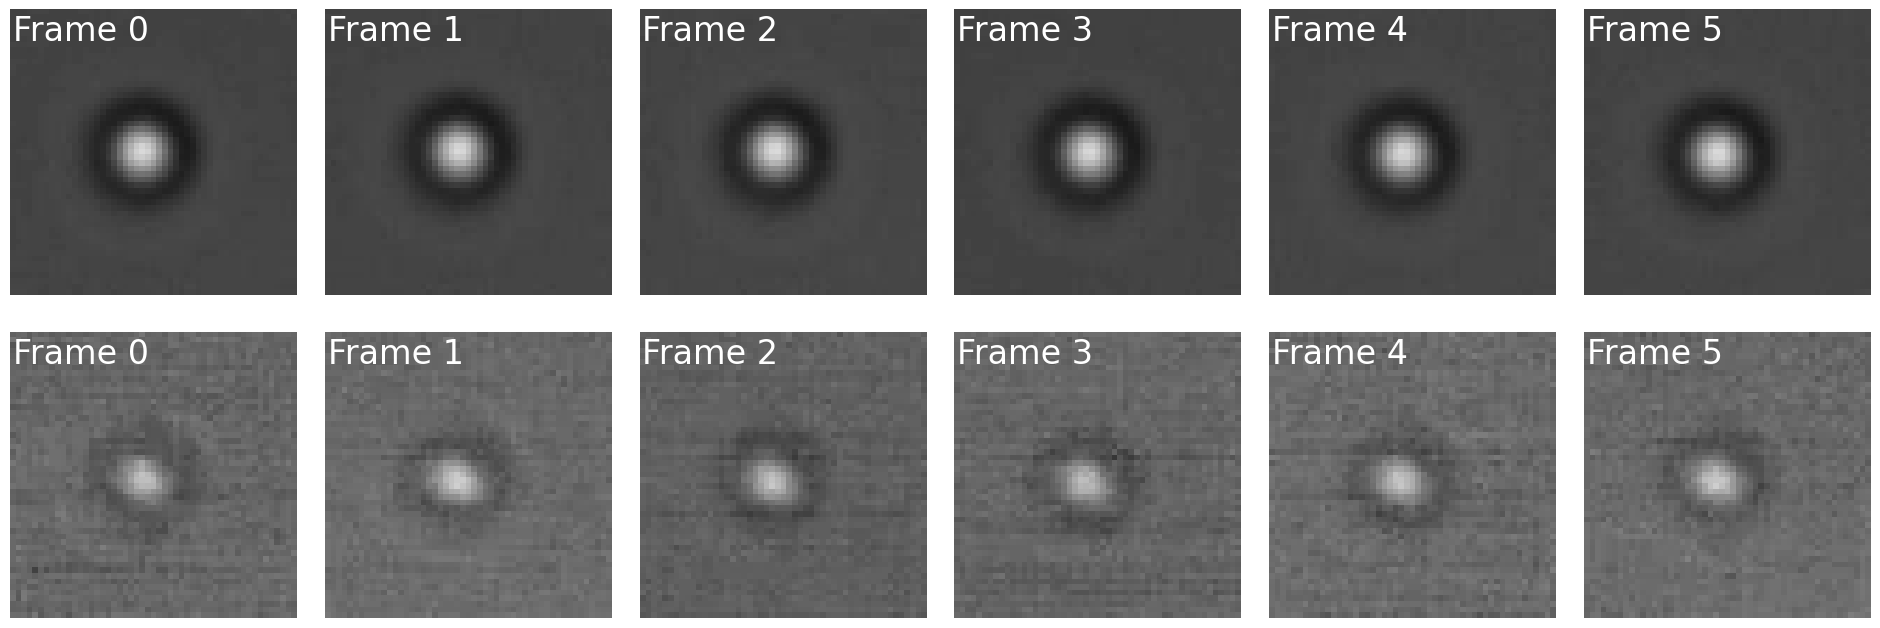

In [282]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(2, 6, figsize=(24, 8))
for i in range(6):
    axs[0, i].imshow(video_low_noise[i], cmap="gray", vmin=0, vmax=1)
    axs[0, i].text(0, 5, f"Frame {i}", color="white", fontsize=24)
    axs[0, i].axis("off")

    axs[1, i].imshow(video_high_noise[i], cmap="gray", vmin=0, vmax=1)
    axs[1, i].text(0, 5, f"Frame {i}", color="white", fontsize=24)
    axs[1, i].axis("off")
plt.subplots_adjust(wspace=0.1, hspace=0.1)
plt.show()

## Manually Annotating the Videos

Define a class to be able to interactively select the centroid of particles in some of the video frames ...

In [283]:
from matplotlib.widgets import Cursor

class ManualAnnotation:
    """Graphical interface for manual annotation."""

    def __init__(self, images):
        """Initialize manual annotation."""
        self.images, self.positions, self.i = images, [], 0
        self.fig, self.ax = plt.subplots(1, 1, figsize=(5, 5))
        self.fig.canvas.header_visible = False
        self.fig.canvas.footer_visible = False

    def start(self):
        """Start manual annotation."""
        self.im = self.ax.imshow(self.images[self.i], cmap="gray",
                                 vmin=0, vmax=1)
        self.text = self.ax.text(3, 5,
                                 f"Frame {self.i + 1} of {len(self.images)}",
                                 color="white", fontsize=12)
        self.ax.axis("off")
        self.cursor = Cursor(self.ax, useblit=True, color="red", linewidth=1)
        self.cid = self.fig.canvas.mpl_connect("button_press_event",
                                               self.onclick)
        self.next_image()
        plt.show()

    def next_image(self):
        """Get next image."""
        self.im.set_data(self.images[self.i])
        self.text.set_text(f"Frame {self.i + 1} of {len(self.images)}")
        self.fig.canvas.draw_idle()

    def onclick(self, event):
        """Save position on click."""
        self.positions.append([event.xdata, event.ydata])
        if self.i < len(self.images) - 1:
            self.i += 1
            self.next_image()
        else:
            self.fig.canvas.mpl_disconnect(self.cid)
            plt.close()
            return

... use it to annotate a subset of images ...

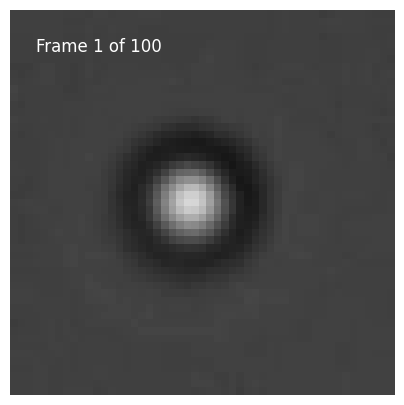

In [284]:


number_of_images_to_annotate = 100

dataset = np.concatenate([video_low_noise, video_high_noise], axis=0)
np.random.shuffle(dataset)
images_to_annotate = np.random.choice(
    np.arange(dataset.shape[0]), number_of_images_to_annotate, replace=False,
)
manual_annotation = ManualAnnotation(dataset[images_to_annotate])
manual_annotation.start()
annotated_images = manual_annotation.images
manual_positions = manual_annotation.positions

%matplotlib inline

... and save the annotated images and relative positions into files.

In [285]:
if not os.path.exists("annotated_images.npy"):
    np.save("annotated_images.npy", np.array(annotated_images))
if not os.path.exists("manual_positions.npy"):
    np.save("manual_positions.npy", np.array(manual_positions))

### Preprocessing the Annotated Data

Define a custom dataset ...

In [286]:
import torch

class AnnotatedDataset(torch.utils.data.Dataset):
    """Manually annotated dataset."""

    def __init__(self, file_images, file_positions):
        """Load annotated images and manual positions."""
        self.images = np.load(file_images)
        self.positions = np.load(file_positions)

    def __len__(self):
        """Return number of images."""
        return self.images.shape[0]

    def __getitem__(self, idx):
        """Get next image and annotated position."""
        im = torch.tensor(self.images[idx, np.newaxis, :, :]).float()
        pos = torch.tensor(self.positions[idx] / im.shape[-1] - 0.5).float()
        return [im, pos]

... create an instance of the dataset with the data you've annotated ...

In [287]:
ann_dataset = AnnotatedDataset(file_images="annotated_images.npy",
                               file_positions="manual_positions.npy")

... and use it to create the data loaders.

In [288]:
import deeplay as dl

train_ann_dataset, test_ann_dataset = \
    torch.utils.data.random_split(ann_dataset, [0.8, 0.2])

train_ann_dataloader = dl.DataLoader(train_ann_dataset, batch_size=1)
test_ann_dataloader = dl.DataLoader(test_ann_dataset, batch_size=1)
ann_dataloader = dl.DataLoader(ann_dataset,batch_size=1)

## Implementing a Convolutional Neural Network for Classification

Sefine a convolutional neural network with a dense top ...

In [289]:
cnn = dl.Sequential(
    dl.ConvolutionalNeuralNetwork(
        in_channels=1, hidden_channels=[16, 32], out_channels=64,
        pool=torch.nn.MaxPool2d(kernel_size=2), out_activation=torch.nn.ReLU,
    ),
    dl.Layer(torch.nn.MaxPool2d, kernel_size=2),
    dl.Layer(torch.nn.Flatten),
    dl.MultiLayerPerceptron(
        in_features=6 * 6 * 64, hidden_features=[32, 32], out_features=1,
        out_activation=torch.nn.Identity,
    ),
)

print(cnn)

Sequential(
  (0): ConvolutionalNeuralNetwork(
    (blocks): LayerList(
      (0): Conv2dBlock(
        (layer): Layer[Conv2d](in_channels=1, out_channels=16, kernel_size=3, stride=1, padding=1)
        (activation): Layer[ReLU]()
      )
      (1): Conv2dBlock(
        (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        (layer): Layer[Conv2d](in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1)
        (activation): Layer[ReLU]()
      )
      (2): Conv2dBlock(
        (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        (layer): Layer[Conv2d](in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        (activation): Layer[ReLU]()
      )
    )
  )
  (1): Layer[MaxPool2d](kernel_size=2)
  (2): Layer[Flatten]()
  (3): MultiLayerPerceptron(
    (blocks): LayerList(
      (0): LinearBlock(
        (layer): Layer[Linear](in_features=2304, out_features=32, bias=True)
        (activa

... and compile it for a regression task.

In [290]:
from torchmetrics import MeanAbsoluteError as MAE

cnn_regressor_template = dl.Regressor(
    model=cnn, loss=torch.nn.MSELoss(), optimizer=dl.Adam(), metrics=[MAE()],
)
cnn_ann_regressor = cnn_regressor_template.create()

print(cnn_ann_regressor)

Regressor(
  (loss): MSELoss()
  (optimizer): Adam[Adam]()
  (train_metrics): MetricCollection(
    (MeanAbsoluteError): MeanAbsoluteError(),
    prefix=train
  )
  (val_metrics): MetricCollection(
    (MeanAbsoluteError): MeanAbsoluteError(),
    prefix=val
  )
  (test_metrics): MetricCollection(
    (MeanAbsoluteError): MeanAbsoluteError(),
    prefix=test
  )
  (model): Sequential(
    (0): ConvolutionalNeuralNetwork(
      (blocks): LayerList(
        (0): Conv2dBlock(
          (layer): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (activation): ReLU()
        )
        (1): Conv2dBlock(
          (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
          (layer): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (activation): ReLU()
        )
        (2): Conv2dBlock(
          (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
          (layer): Conv2d(32, 64,

## Simulating the Training Data

Define the particle ...

In [291]:
import deeptrack as dt

particle = dt.scatterers.MieSphere(
    position=lambda: np.random.uniform(image_size / 2 - 5,
                                       image_size / 2 + 5, 2),
    z=lambda: np.random.uniform(-1, 1),
    radius=lambda: np.random.uniform(400, 800) * 1e-9,
    refractive_index=lambda: np.random.uniform(1.37, 1.42),
    position_unit="pixel",
)

... specify the optical device to image the particle ...

In [292]:
brightfield_microscope = dt.optics.Brightfield(
    wavelength=630e-9, NA=0.8, resolution=1e-6, magnification=15,
    refractive_index_medium=1.33, output_region=(0, 0, image_size, image_size),
)

... combine them ...

In [293]:
imaged_particle = brightfield_microscope(particle)

... and plot them.

In [294]:
def plot_simulated_particles(image_pipeline):
    """Plot simulated particles."""
    fig, axs = plt.subplots(1, 6, figsize=(25, 8))
    for i, ax in enumerate(axs.flatten()):
        image = image_pipeline.update().resolve()
        ax.imshow(np.squeeze(image), cmap="gray")
        ax.set_xticks([])
        ax.set_yticks([])
    plt.show()

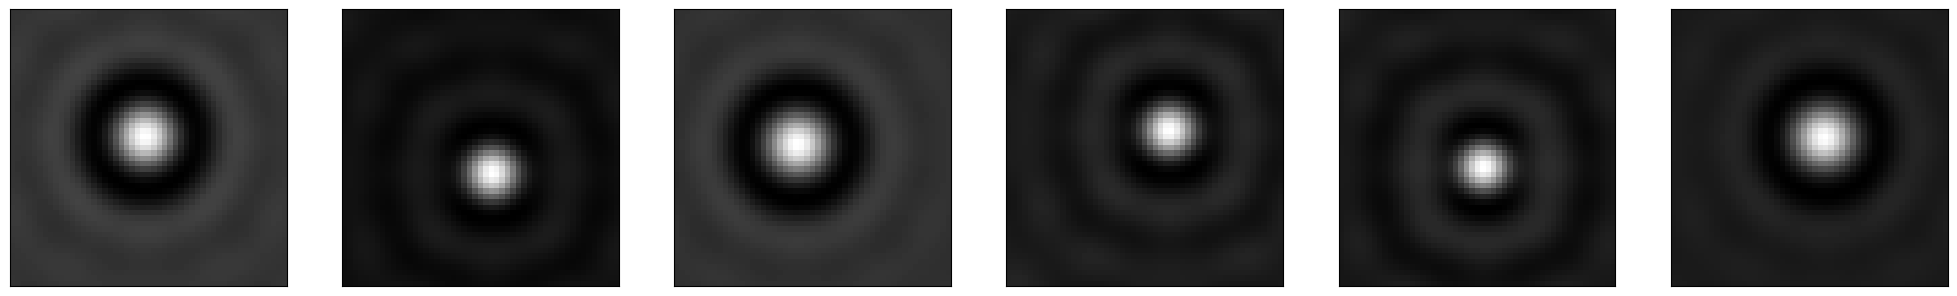

In [295]:
plot_simulated_particles(imaged_particle)

### Creating Images of Particles with Noise

Adding a Poisson noise source to the simulation pipeline ...

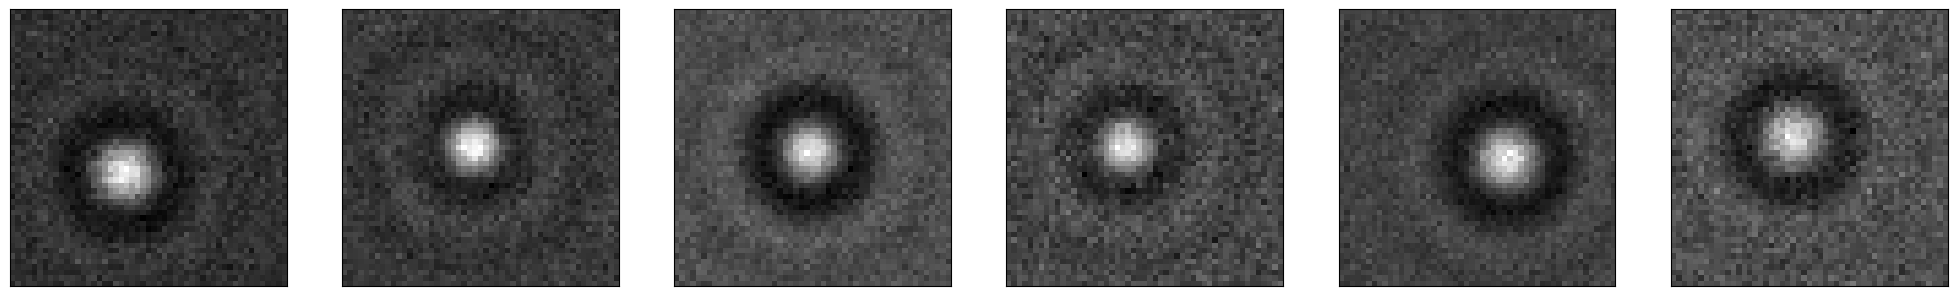

In [296]:
noise = dt.Poisson(
    min_snr=5, max_snr=20, background=1,
    snr=lambda min_snr, max_snr: np.random.uniform(min_snr, max_snr),
)
noisy_imaged_particle = imaged_particle >> noise

plot_simulated_particles(noisy_imaged_particle)

... and create a pipeline that generates noisy particle images and normalize the pixel values.

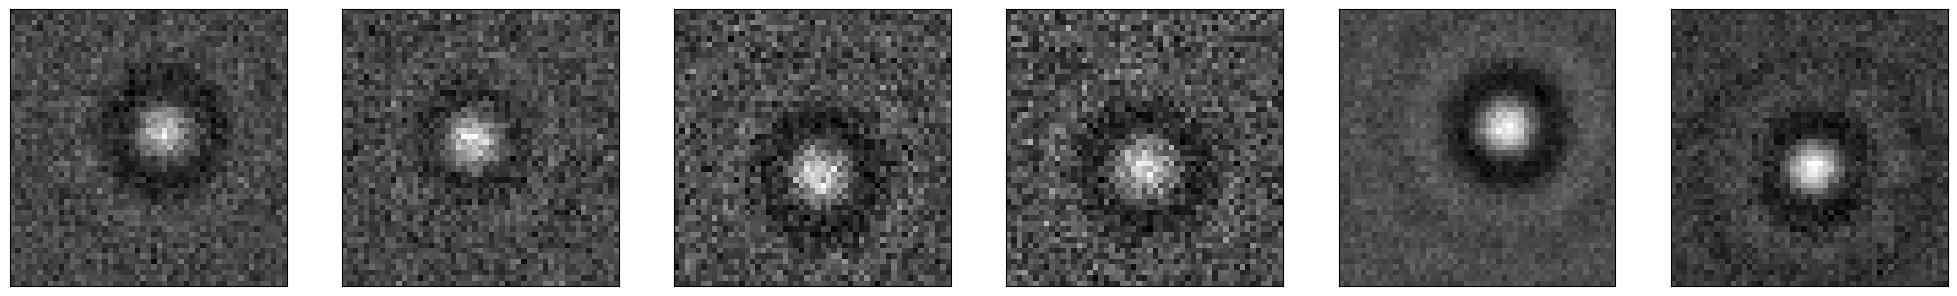

In [297]:
normalization = dt.NormalizeMinMax(lambda: np.random.uniform(0.0, 0.2),
                                   lambda: np.random.uniform(0.8, 1.0))
image_pipeline = noisy_imaged_particle >> normalization

plot_simulated_particles(image_pipeline)

### Getting the Positions from the Simulated Images

Define a pipeline to obtain both the particle image and its centroid position ...

In [298]:
pipeline = image_pipeline & particle.radius

... and plot the particle positions on top of the particle images.

In [299]:
def plot_simulated_particles_with_positions(pipeline):
    """Plot simulated particles with positions."""
    fig, axs = plt.subplots(1, 6, figsize=(25, 8))
    for i, ax in enumerate(axs.flatten()):
        image, radius = pipeline.update().resolve()
        print(image.shape)
        ax.imshow(np.squeeze(image), cmap="gray")
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(f"Radius = {radius*1e+9:.2f}nm", fontsize=12, color="blue")
    plt.show()

(51, 51, 1)
(51, 51, 1)
(51, 51, 1)
(51, 51, 1)
(51, 51, 1)
(51, 51, 1)


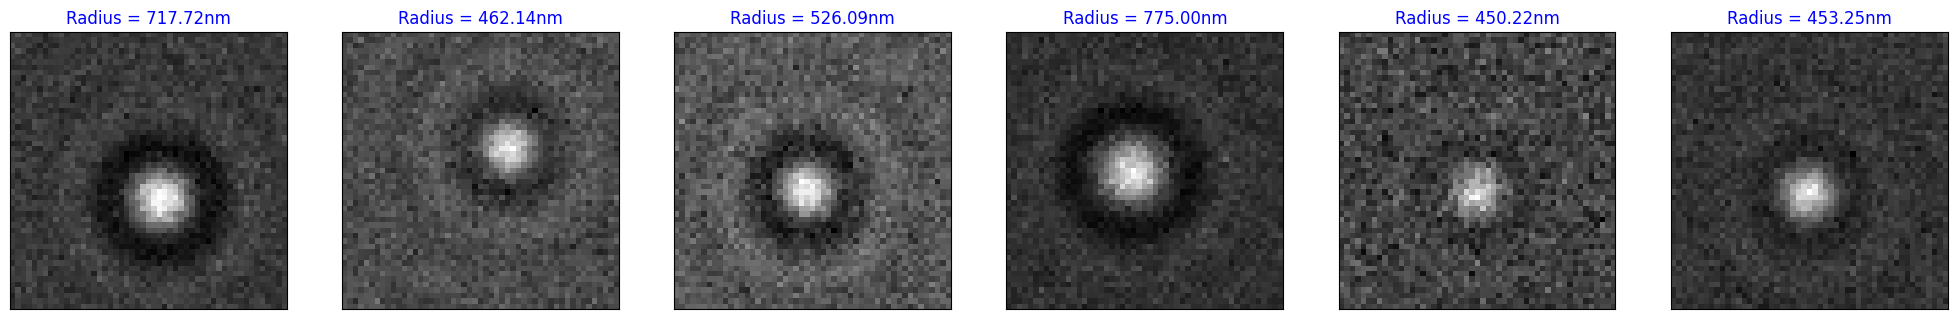

In [300]:
plot_simulated_particles_with_positions(pipeline)

### Preprocessing the Simulated Data

Create a database to work with the simulated particle images ...

In [301]:
class SimulatedDataset(torch.utils.data.Dataset):
    """Dataset with simulated particles."""

    def __init__(self, pipeline, data_size):
        """Initialize simulated dataset."""
        images, radiusli = [], []
        for _ in range(data_size):
            image, radius = pipeline.update().resolve()
            images.append(image), radiusli.append(radius*1e+9)
        self.images, self.radiusli = np.array(images), np.array(radiusli).reshape(-1, 1)

    def __len__(self):
        """Return number of images."""
        return self.images.shape[0]

    def __getitem__(self, idx):
        """Get next simulated image and position."""
        im = torch.tensor(self.images[idx]).float().permute(2, 0, 1)
        rad = torch.tensor(self.radiusli[idx]).float()
        return [im, rad]

... and create the training and test data loaders.

In [302]:
train_sim_dataloader = dl.DataLoader(
    SimulatedDataset(pipeline=pipeline, data_size=30000), batch_size=32,
)
test_sim_dataloader = dl.DataLoader(
    SimulatedDataset(pipeline=pipeline, data_size=3000), batch_size=32,
)



## Training the Neural Network with Simulated Data

In [303]:
cnn_sim_regressor = cnn_regressor_template.create()
cnn_sim_trainer = dl.Trainer(max_epochs=50, accelerator="auto")
for data in train_sim_dataloader:
    print(data[0].shape, data[1].shape)
    break
cnn_sim_trainer.fit(cnn_sim_regressor, train_sim_dataloader)

INFO: 
  | Name          | Type             | Params | Mode 
-----------------------------------------------------------
0 | loss          | MSELoss          | 0      | train
1 | train_metrics | MetricCollection | 0      | train
2 | val_metrics   | MetricCollection | 0      | train
3 | test_metrics  | MetricCollection | 0      | train
4 | model         | Sequential       | 98.1 K | train
5 | optimizer     | Adam             | 0      | train
-----------------------------------------------------------
98.1 K    Trainable params
0         Non-trainable params
98.1 K    Total params
0.393     Total estimated model params size (MB)
34        Modules in train mode
0         Modules in eval mode
INFO:lightning.pytorch.callbacks.model_summary:
  | Name          | Type             | Params | Mode 
-----------------------------------------------------------
0 | loss          | MSELoss          | 0      | train
1 | train_metrics | MetricCollection | 0      | train
2 | val_metrics   | MetricCollec

torch.Size([32, 1, 51, 51]) torch.Size([32, 1])


Training: |          | 0/? [00:00<?, ?it/s]

In [304]:
cnn_sim_regressor

Regressor(
  (loss): MSELoss()
  (optimizer): Adam[Adam](params=<generator object Module.parameters at 0x7a14d44f9540>)
  (train_metrics): MetricCollection(
    (MeanAbsoluteError): MeanAbsoluteError(),
    prefix=train
  )
  (val_metrics): MetricCollection(
    (MeanAbsoluteError): MeanAbsoluteError(),
    prefix=val
  )
  (test_metrics): MetricCollection(
    (MeanAbsoluteError): MeanAbsoluteError(),
    prefix=test
  )
  (model): Sequential(
    (0): ConvolutionalNeuralNetwork(
      (blocks): LayerList(
        (0): Conv2dBlock(
          (layer): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (activation): ReLU()
        )
        (1): Conv2dBlock(
          (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
          (layer): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (activation): ReLU()
        )
        (2): Conv2dBlock(
          (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, d

### Testing the Trained Neural Network

In [305]:
test_sim_results = cnn_sim_trainer.test(cnn_sim_regressor, test_sim_dataloader)
MAE_sim = test_sim_results[0]["testMeanAbsoluteError_epoch"] * image_size
print(f"Mean pixel error (MAE): {MAE_sim:.3f} pixels")

Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃         Test metric         ┃        DataLoader 0         ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ testMeanAbsoluteError_epoch │     17.394935607910156      │
│       test_loss_epoch       │      487.2689514160156      │
└─────────────────────────────┴─────────────────────────────┘

Mean pixel error (MAE): 887.142 pixels


### Plotting the Predictions Versus the Ground Truth

流式输出内容被截断，只能显示最后 5000 行内容。
        [772.0162],
        [759.7196],
        [557.2427],
        [510.5238],
        [580.9164],
        [649.2168],
        [737.9270],
        [579.2324],
        [480.9795],
        [692.9996],
        [622.3760],
        [710.1785],
        [717.3935],
        [658.7445],
        [493.0252],
        [630.3239],
        [587.9550],
        [432.7841],
        [534.1343],
        [634.1580],
        [520.7391],
        [442.4550],
        [687.8643],
        [423.2149]], grad_fn=<AddmmBackward0>)
gts = tensor([[658.8727],
        [657.4929],
        [653.7396],
        [416.6882],
        [509.6254],
        [619.4109],
        [526.1976],
        [568.1816],
        [725.1102],
        [562.3160],
        [739.8533],
        [478.3370],
        [685.1899],
        [694.8223],
        [427.0099],
        [793.6160],
        [469.4251],
        [482.6924],
        [703.0198],
        [539.6663],
        [460.6598],
        [692.7075],
        [780.1044],


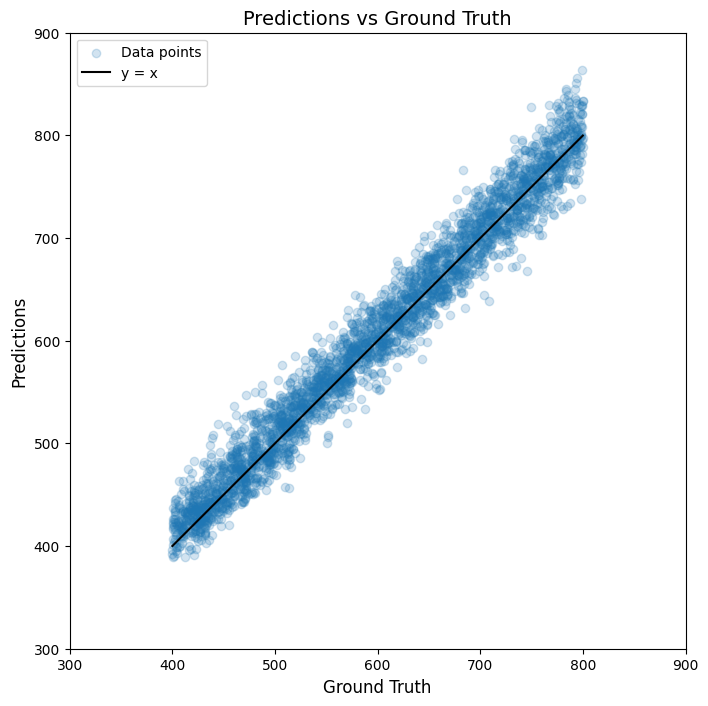

In [306]:
preds, gts = [], []
for image, radius in iter(test_sim_dataloader):
    preds.append(cnn_sim_regressor(image))
    gts.append(radius)
    print(f"gts = {radius}")
    print(f"preds = {cnn_sim_regressor(image)}")
preds = torch.cat(preds, dim=0).detach().numpy()
gts = torch.cat(gts, dim=0).numpy()

fig, ax = plt.subplots(1, 1, figsize=(8, 8))
gt = gts[:, 0]
pred = preds[:, 0]

ax.scatter(gt, pred, alpha=0.2, label="Data points")
ax.plot([np.min(gt), np.max(gt)], [np.min(gt), np.max(gt)], c="k", label="y = x")

ax.set_title("Predictions vs Ground Truth", fontsize=14)
ax.set_xlabel("Ground Truth", fontsize=12)
ax.set_ylabel("Predictions", fontsize=12)

ax.set_xlim([300,900])
ax.set_ylim([300,900])

ax.set_aspect("equal")

ax.legend()

plt.show()


### Comparing with the Annotated Data

In [307]:
import matplotlib.pyplot as plt
import torch

for images, labels in ann_dataloader:
    for i in range(images.shape[0]):
        single_image = images[i].unsqueeze(0)

        cnn_sim_regressor.eval()
        with torch.no_grad():
            pred = cnn_sim_regressor(single_image)

        pred_radius = pred.item()

        print(f"Predicted Radius is {pred_radius}")


Predicted Radius is 467.5975646972656
Predicted Radius is 457.7082824707031
Predicted Radius is 521.9383544921875
Predicted Radius is 518.7002563476562
Predicted Radius is 509.61163330078125
Predicted Radius is 518.9996948242188
Predicted Radius is 541.3369140625
Predicted Radius is 495.72998046875
Predicted Radius is 471.87579345703125
Predicted Radius is 484.9430847167969
Predicted Radius is 485.1263427734375
Predicted Radius is 481.5533447265625
Predicted Radius is 463.9328308105469
Predicted Radius is 450.1610412597656
Predicted Radius is 513.4539794921875
Predicted Radius is 540.3106079101562
Predicted Radius is 476.6944885253906
Predicted Radius is 542.7154541015625
Predicted Radius is 476.0246887207031
Predicted Radius is 517.5262451171875
Predicted Radius is 483.1581115722656
Predicted Radius is 512.0404663085938
Predicted Radius is 470.8851318359375
Predicted Radius is 510.1116638183594
Predicted Radius is 518.7221069335938
Predicted Radius is 539.90966796875
Predicted Radius 

In [308]:
from PIL import Image

im_ind = 0
for images in test_sim_dataloader:
    image = images[im_ind]
    break


print(image)

tensor([[[[0.1570, 0.1856, 0.1726,  ..., 0.1908, 0.1674, 0.1908],
          [0.1700, 0.2376, 0.2220,  ..., 0.2038, 0.2168, 0.1908],
          [0.1700, 0.1648, 0.2610,  ..., 0.2246, 0.1752, 0.2220],
          ...,
          [0.1596, 0.2402, 0.2246,  ..., 0.1986, 0.1596, 0.1415],
          [0.1778, 0.1519, 0.2168,  ..., 0.2480, 0.1441, 0.1752],
          [0.2662, 0.1622, 0.1882,  ..., 0.2272, 0.2454, 0.2038]]],


        [[[0.2337, 0.1313, 0.2109,  ..., 0.1654, 0.2337, 0.2337],
          [0.2223, 0.2223, 0.2678,  ..., 0.2678, 0.3020, 0.1882],
          [0.3703, 0.2337, 0.2564,  ..., 0.3020, 0.2223, 0.1882],
          ...,
          [0.3589, 0.1654, 0.1995,  ..., 0.2564, 0.2792, 0.2451],
          [0.1540, 0.2223, 0.2223,  ..., 0.2451, 0.2906, 0.1654],
          [0.2792, 0.3247, 0.1654,  ..., 0.2564, 0.2337, 0.1995]]],


        [[[0.3045, 0.2904, 0.2414,  ..., 0.3360, 0.3465, 0.2519],
          [0.2519, 0.3921, 0.3010,  ..., 0.3220, 0.3290, 0.2939],
          [0.3045, 0.3290, 0.2975,  ..

In [309]:
def plot_activations(activations, cols=8):
    """Visualize activations."""
    rows = -(activations.shape[0] // -cols)

    fig, axs = plt.subplots(rows, cols, figsize=(2 * cols, 2 * rows))
    for i, ax in enumerate(axs.ravel()):
        ax.axis("off")
        if i < activations.shape[0]:
            ax.imshow(activations[i].numpy())
            ax.set_title(i, fontsize=16)
    plt.show()

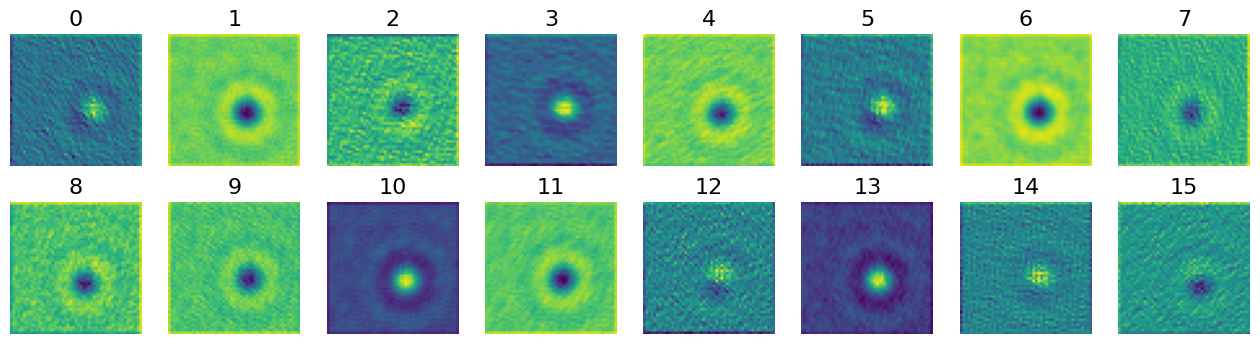

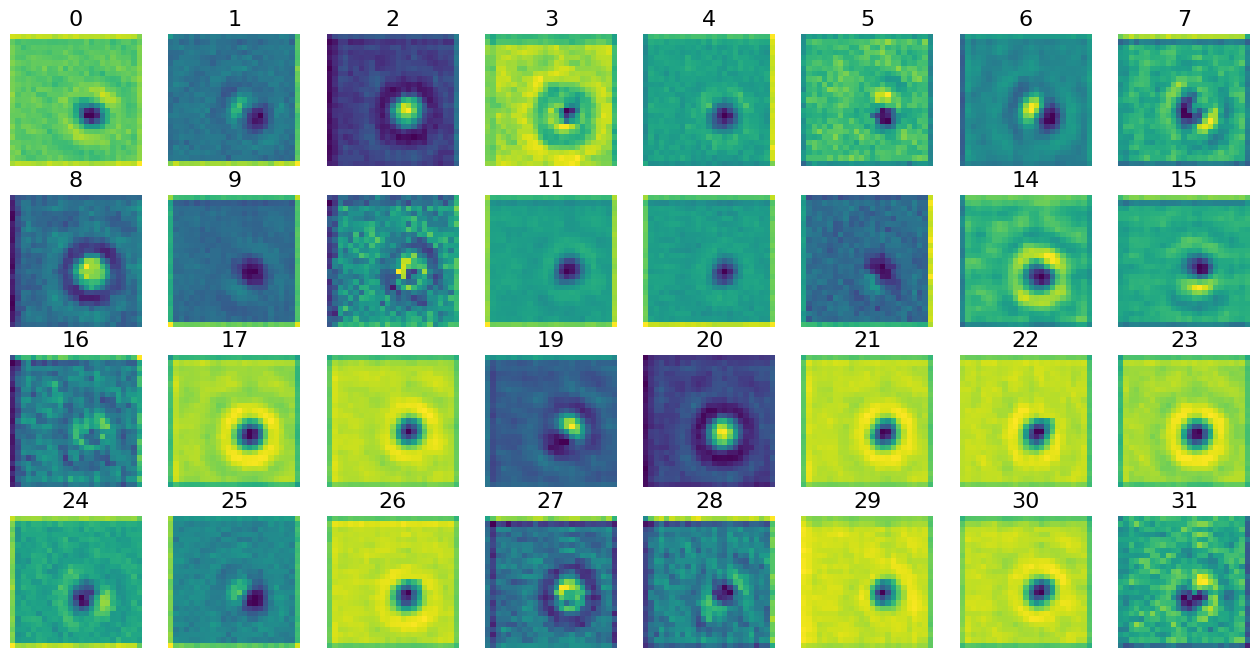

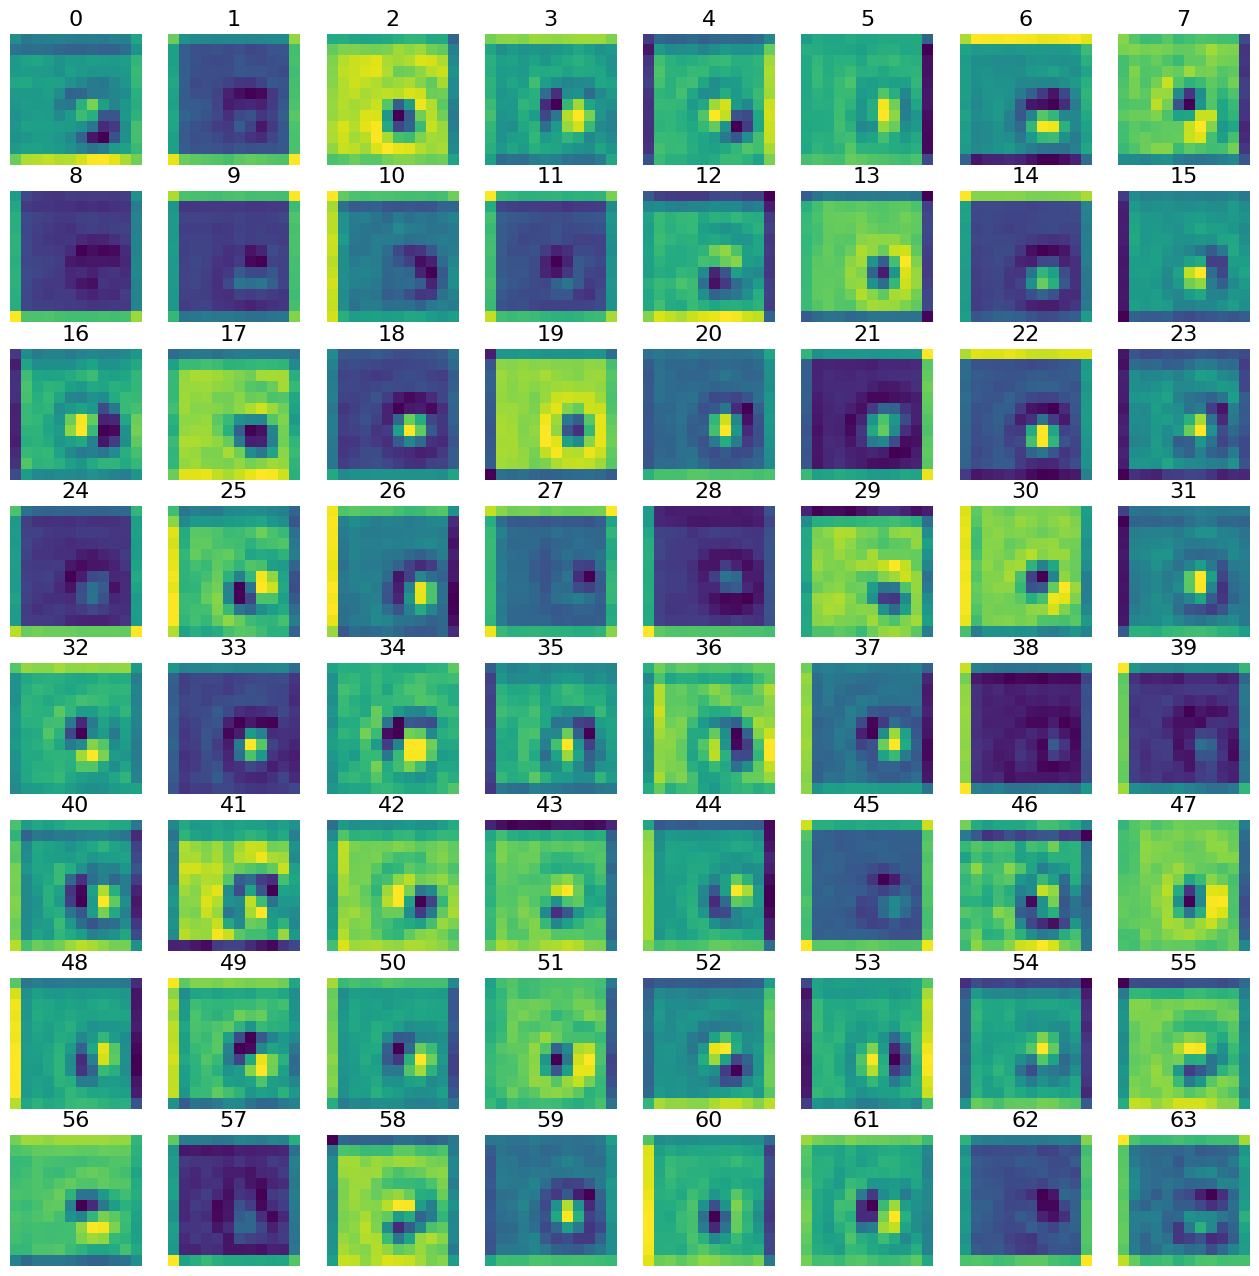

In [310]:
def hook_func(layer, input, output):
    """Hook for activations."""
    activations = output.detach().clone()
    plot_activations(activations[0])

for block in cnn_sim_regressor.model[0].blocks:
    layer = block.layer
    handle_hook = layer.register_forward_hook(hook_func)

    try:
        pred = cnn_sim_regressor.model(image)
    except Exception as e:
        print(f"An error occurred during model prediction: {e}")
    finally:
        handle_hook.remove()

In [311]:
from PIL import Image

im_ind = 0
for images in ann_dataloader:
    image = images[im_ind]
    break


print(image)

tensor([[[[0.3659, 0.3940, 0.4132,  ..., 0.4181, 0.4120, 0.3850],
          [0.4330, 0.3768, 0.4291,  ..., 0.4078, 0.4156, 0.3884],
          [0.3638, 0.3403, 0.3551,  ..., 0.3964, 0.4110, 0.4041],
          ...,
          [0.4339, 0.3979, 0.3992,  ..., 0.4238, 0.4203, 0.4193],
          [0.3862, 0.3696, 0.3764,  ..., 0.4064, 0.4076, 0.3999],
          [0.4088, 0.3928, 0.4303,  ..., 0.4157, 0.4157, 0.4105]]]])


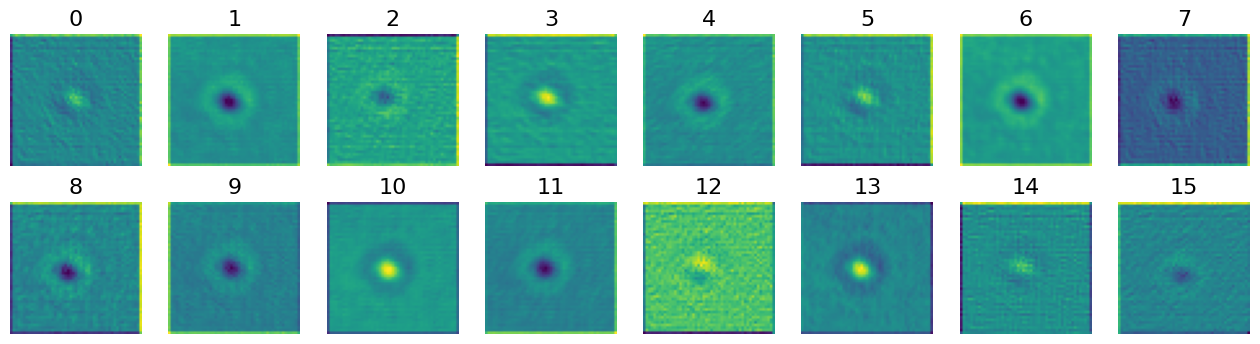

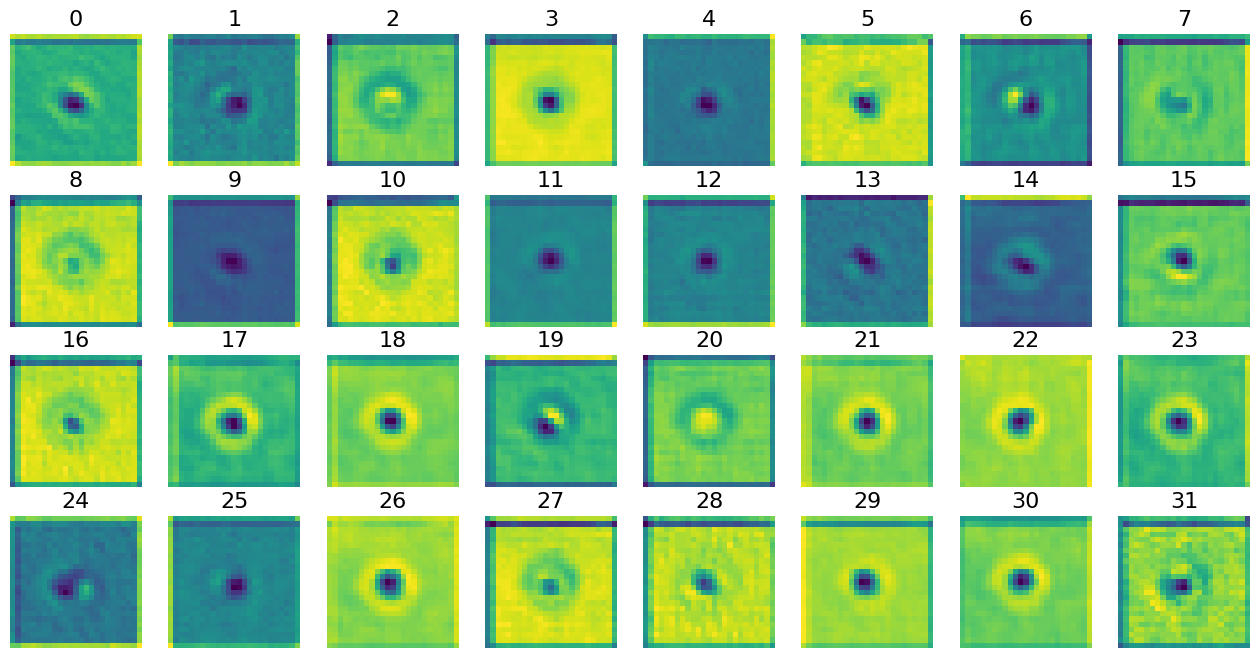

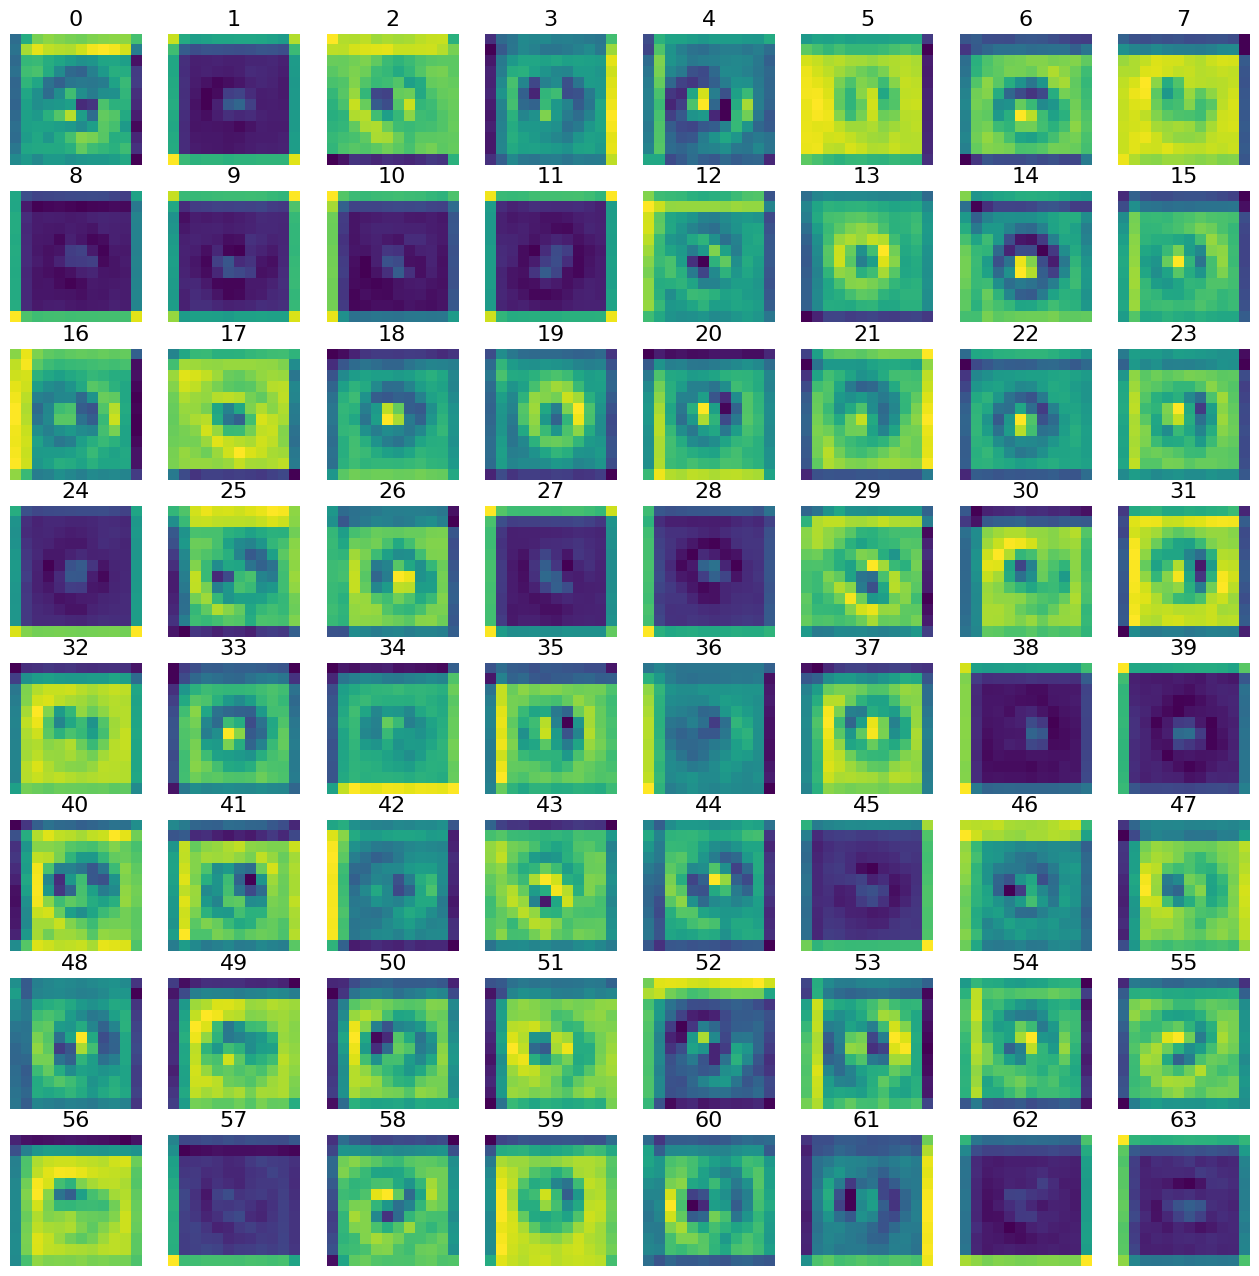

In [312]:
for block in cnn_sim_regressor.model[0].blocks:
    layer = block.layer
    handle_hook = layer.register_forward_hook(hook_func)

    try:
        pred = cnn_sim_regressor.model(image)
    except Exception as e:
        print(f"An error occurred during model prediction: {e}")
    finally:
        handle_hook.remove()